In [1]:
!pip install yfinance
!pip install torchsummaryX
!pip install wandb -q

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 329 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 12.9 MB/s 
     |████████████████████████████████| 168 kB 55.8 MB/s 
     |████████████████████████████████| 182 kB 70.3 MB/s 
     |████████████████████████████████| 62 kB 1.3 MB/s 
     |████████████████████████████████| 140 kB 77.6 MB/s 


In [2]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import time
import os
import yfinance as yf
import pandas as pd
import datetime
import torch
import torch.nn as nn
from torchsummaryX import summary
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import gc

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.getcwd()

Mounted at /content/drive


'/content'

In [4]:
import wandb
wandb.login(key="03916b709446813b51f72a1b29a2854a9dd9e3f7")

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
# Training Config
config = {
    "batch_size" : 30,
    "lr" : 1e-3,
    "epochs" : 100,
    "look_back" : 60,
    "feature_dim" : 1,
    "hidden_dim" : 50,
    "output_dim" : 1,
    "num_layers" : 1,
    "dropout" : 0
}

In [6]:
# load all that we need
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 150)

class VolatiltiyData:

    def __init__(self, tickers, start_year, start_month, start_date, end_year,
                 end_month, end_date, freq, scaling_factor, windows, y_window):
        self.tickers = tickers
        self.start = datetime.datetime(start_year, start_month, start_date)
        self.end = datetime.datetime(end_year, end_month, end_date)
        self.freq = freq
        self.scaling_factor = scaling_factor
        # 过去几天的vol
        self.windows = windows
        # Predict几天的vol
        self.y_window = y_window 

    def get_data(self):
        """
        Output:
        raw data -> ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Log Adj Close', 'Log Return', 10-day-vol']
        """
        data = yf.download(self.tickers, start = self.start, end = self.end, interval = self.freq)
        data["Log Adj Close"] = np.log(data["Adj Close"])
        data["Log Return"] = np.insert(np.diff(data["Log Adj Close"]), 0, 0) * 100
        data["10-day-vol"] = data["Log Return"].rolling(10).std(ddof=0)
        return data
    
    def prepare_data(self, data):
        """
        Prepare data for training. Select features that are needed. Perform necessary normalization.
        
        For volatiltiy data, we need to remove initial n days since we need at least n days to calculate volatiltiy.

        Output:
        dataset ->  (samples, features)
        scalar  ->  scalar for our normalization
        """
        vol_10 = data['10-day-vol'].values
        dataset = vol_10.reshape(-1, 1)[11:]
        
        # normalize the dataset
        scaler = MinMaxScaler(feature_range=(0, 1))
        dataset = scaler.fit_transform(dataset)
        return dataset, scaler

volatiltiy_data = VolatiltiyData(
                      "^GSPC",
                      1990, 1, 2,
                      2022, 12, 12,
                      freq="1d",
                      scaling_factor=100,
                      windows=[10], # 过去几天的vol
                      y_window=10 # Predict几天的vol
                  )

data = volatiltiy_data.get_data()
dataset, scaler = volatiltiy_data.prepare_data(data)
print(np.shape(dataset))

[*********************100%***********************]  1 of 1 completed
(8290, 1)


In [7]:
class DataLoaderForVolatilityModeling(DataLoader):
    """
    Construct dataloader
  
    The label for our data is the next 10-day volatility after our input.

    Output:
    input -> (batch_size, seq_len, feature_size)
    label -> (batch_size, 1, feature_size) 
    """
    def __init__(self, dataset, batch_size, sequence_length, shuffle=True, feature_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.sequence_length = sequence_length
        self.num_batches = (np.shape(self.dataset)[0]-10) // self.batch_size
        self.feature_size = feature_size

    def __len__(self):
        return self.num_batches - self.sequence_length

    def __iter__(self):
        # group the sequence into batches
        x = torch.from_numpy(np.reshape(self.dataset[:self.num_batches*self.batch_size, :], (self.batch_size, -1))).type(torch.float32)
        y = torch.from_numpy(np.reshape(self.dataset[10:self.num_batches*self.batch_size+10, :], (self.batch_size, -1))).type(torch.float32)

        # return a tuple of (input, label) on every iteration with yield
        index = 0
        while index+self.sequence_length < self.num_batches:
            time_steps = self.sequence_length
            input = x[:, index:index+time_steps].view(self.batch_size, time_steps, self.feature_size)
            label = y[:, index+time_steps].view(self.batch_size, self.feature_size)
            index += 1
            yield input, label

In [8]:
# sanity check
dataloader = DataLoaderForVolatilityModeling(dataset, batch_size=config["batch_size"], sequence_length=config["look_back"])
tmp = iter(dataloader)
input, label = next(tmp)
print(f'input shape = {np.shape(input)}')
print(f'label shape = {np.shape(label)}')

input shape = torch.Size([30, 60, 1])
label shape = torch.Size([30, 1])


In [9]:
# model
class Model(nn.Module):
    """
    Construct model architecture
    """
    def __init__(self, feature_dim, hidden_dim, output_dim):
        super(Model, self).__init__()
        self.lstm = torch.nn.LSTM(input_size=feature_dim, hidden_size=hidden_dim, num_layers=config["num_layers"], 
                                  dropout=config["dropout"], batch_first=True, bias=True)
        self.relu = torch.nn.ReLU()
        self.linear = torch.nn.Linear(in_features=hidden_dim, out_features=output_dim, bias=True)

    def forward(self, x):
        x, h = self.lstm(x)
        x = x[:, -1, :]
        # x = self.relu(x)
        x = self.linear(x)
        return x

In [10]:
# sanity check
torch.cuda.empty_cache()

model = Model(config['feature_dim'], config['hidden_dim'], config['output_dim']).to(device)
prediction = model(input.to(device))
print(f'shape of prediction : {prediction.shape}')
print(f'shape of label : {label.shape}')

summary(model, input.to(device))

shape of prediction : torch.Size([30, 1])
shape of label : torch.Size([30, 1])
         Kernel Shape  Output Shape  Params  Mult-Adds
Layer                                                 
0_lstm              -  [30, 60, 50]   10600      10200
1_linear      [50, 1]       [30, 1]      51         50
------------------------------------------------------
                      Totals
Total params           10651
Trainable params       10651
Non-trainable params       0
Mult-Adds              10250


/usr/local/lib/python3.8/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_lstm,-,"[30, 60, 50]",10600,10200
1_linear,"[50, 1]","[30, 1]",51,50


In [11]:
# Prepare loader
train_size = int(len(dataset) * 0.5)
val_size = int(len(dataset) * 0.2)
test_size = len(dataset) - train_size - val_size
train_data, val_data, test_data = dataset[0:train_size,:], dataset[train_size:train_size+val_size,:], dataset[train_size+val_size:len(dataset),:]

train_loader = DataLoaderForVolatilityModeling(train_data, batch_size=config['batch_size'], sequence_length=config['look_back'], shuffle=True)
val_loader = DataLoaderForVolatilityModeling(val_data, batch_size=10, sequence_length=config['look_back'], shuffle=False)
test_loader = DataLoaderForVolatilityModeling(test_data, batch_size=1, sequence_length=config['look_back'], shuffle=False)

# Prepare optimizer, criterion, and scheduler_lr
optimizer = torch.optim.SGD(model.parameters(), lr=config['lr'], weight_decay = 5e-5) # What goes in here?
criterion = torch.nn.MSELoss()
scheduler_lr = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.75, patience=2, verbose=True)

In [12]:
# Evaluate
def evaluate(val_loader, model, criterion):
    model.eval()

    batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, position=0, leave=False, desc="Val")

    val_loss = 0

    preds, targets = [], []

    for i, (input, target) in enumerate(val_loader):

        input, target = input.to(device), target.to(device)

        with torch.inference_mode():
            prediction = model(input)

        loss = criterion(prediction, target)

        val_loss += loss.item()

        prediction = prediction.cpu().detach().numpy() # (batch_size, feature_size)
        target = target.cpu().detach().numpy() # (batch_size, feature_size)

        preds.append(prediction.flatten())
        targets.append(target.flatten())

        batch_bar.set_postfix(
            loss = f"{val_loss/ (i+1):.4f}",
            lr = f"{curr_lr}"
        )

        batch_bar.update()

        torch.cuda.empty_cache()

    batch_bar.close()

    preds = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

    targets = scaler.inverse_transform(np.array(targets).reshape(-1, 1))

    val_loss = criterion(torch.from_numpy(preds), torch.from_numpy(targets))

    return val_loss

In [13]:
# Train Step
def train_step(train_loader, model, optimizer, criterion):
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
    train_loss = 0
    model.train()

    for i, (input, target) in enumerate(train_loader):
        input, target = input.to(device), target.to(device)
        curr_lr = optimizer.param_groups[0]['lr']

        optimizer.zero_grad()
        prediction = model(input)
        # print(f'prediction : {prediction}')
        # print(f'target : {target}')
        loss = criterion(prediction.flatten(), target.flatten())
        # print(f'loss : {loss.item()}')

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        batch_bar.set_postfix(
            loss = f"{train_loss/ (i+1):.4f}",
            lr = f"{curr_lr}"
        )

        batch_bar.update()

        torch.cuda.empty_cache()
        del input
        del target
    
    batch_bar.close()
    train_loss /= len(train_loader)
    
    return train_loss

In [14]:
# Initialize wandb
run = wandb.init(
    name = "LSTM_abs_base", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "10701_Volatility_Prediction", ### Project should be created in your wandb account 
    config = config ### Wandb Config for your run
)

wandb: Currently logged in as: quantoalpha. Use `wandb login --relogin` to force relogin


In [15]:
best_val_loss = 100

# Train loop
torch.cuda.empty_cache()
gc.collect()

train_loss, val_loss = 0, 0

for epoch in range(config["epochs"]):
    
    curr_lr = optimizer.param_groups[0]['lr']

    train_loss = train_step(train_loader, model, optimizer, criterion)

    val_loss = evaluate(val_loader, model, criterion)

    # scheduler_lr.step(train_loss)

    print("\nEpoch {}/{}: \n\t Train Loss {:.07f}\t Eval Loss {:.07f}\t Learning Rate {:.04f}\t".format(
          epoch + 1,
          config['epochs'],
          train_loss,
          val_loss,
          curr_lr))
    
    wandb.log({"train_loss":train_loss, 'val_loss': val_loss, "learning_Rate": curr_lr})
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        path = '/content/drive/MyDrive/10701/checkpoint/checkpoint_eval_loss_bidrectional'
        torch.save({'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler': scheduler_lr.state_dict(),
                    'val_loss': val_loss, 
                    'epoch': epoch}, path)
wandb.save(path)
run.finish()


Epoch 1/100: 
	 Train Loss 0.0143087	 Eval Loss 1.8810918	 Learning Rate 0.0010	



Epoch 2/100: 
	 Train Loss 0.0106226	 Eval Loss 1.6542985	 Learning Rate 0.0010	



Epoch 3/100: 
	 Train Loss 0.0082010	 Eval Loss 1.4928880	 Learning Rate 0.0010	



Epoch 4/100: 
	 Train Loss 0.0066110	 Eval Loss 1.3768134	 Learning Rate 0.0010	



Epoch 5/100: 
	 Train Loss 0.0055675	 Eval Loss 1.2924403	 Learning Rate 0.0010	



Epoch 6/100: 
	 Train Loss 0.0048832	 Eval Loss 1.2304392	 Learning Rate 0.0010	



Epoch 7/100: 
	 Train Loss 0.0044347	 Eval Loss 1.1843834	 Learning Rate 0.0010	



Epoch 8/100: 
	 Train Loss 0.0041410	 Eval Loss 1.1498114	 Learning Rate 0.0010	



Epoch 9/100: 
	 Train Loss 0.0039488	 Eval Loss 1.1235995	 Learning Rate 0.0010	



Epoch 10/100: 
	 Train Loss 0.0038231	 Eval Loss 1.1035399	 Learning Rate 0.0010	



Epoch 11/100: 
	 Train Loss 0.0037410	 Eval Loss 1.0880566	 Learning Rate 0.0010	



Epoch 12/100: 
	 Train Loss 0.0036874	 Eval Loss 1.0760128	 Learning Rate 0.0010	



Epoch 13/100: 
	 Train Loss 0.0036524	 Eval Loss 1.0665789	 Learning Rate 0.0010	



Epoch 14/100: 
	 Train Loss 0.0036297	 Eval Loss 1.0591440	 Learning Rate 0.0010	



Epoch 15/100: 
	 Train Loss 0.0036149	 Eval Loss 1.0532517	 Learning Rate 0.0010	



Epoch 16/100: 
	 Train Loss 0.0036052	 Eval Loss 1.0485595	 Learning Rate 0.0010	



Epoch 17/100: 
	 Train Loss 0.0035990	 Eval Loss 1.0448067	 Learning Rate 0.0010	



Epoch 18/100: 
	 Train Loss 0.0035949	 Eval Loss 1.0417936	 Learning Rate 0.0010	



Epoch 19/100: 
	 Train Loss 0.0035922	 Eval Loss 1.0393648	 Learning Rate 0.0010	



Epoch 20/100: 
	 Train Loss 0.0035905	 Eval Loss 1.0374006	 Learning Rate 0.0010	



Epoch 21/100: 
	 Train Loss 0.0035893	 Eval Loss 1.0358064	 Learning Rate 0.0010	



Epoch 22/100: 
	 Train Loss 0.0035885	 Eval Loss 1.0345076	 Learning Rate 0.0010	



Epoch 23/100: 
	 Train Loss 0.0035880	 Eval Loss 1.0334457	 Learning Rate 0.0010	



Epoch 24/100: 
	 Train Loss 0.0035876	 Eval Loss 1.0325739	 Learning Rate 0.0010	



Epoch 25/100: 
	 Train Loss 0.0035873	 Eval Loss 1.0318552	 Learning Rate 0.0010	



Epoch 26/100: 
	 Train Loss 0.0035870	 Eval Loss 1.0312594	 Learning Rate 0.0010	



Epoch 27/100: 
	 Train Loss 0.0035868	 Eval Loss 1.0307627	 Learning Rate 0.0010	



Epoch 28/100: 
	 Train Loss 0.0035866	 Eval Loss 1.0303459	 Learning Rate 0.0010	



Epoch 29/100: 
	 Train Loss 0.0035864	 Eval Loss 1.0299940	 Learning Rate 0.0010	



Epoch 30/100: 
	 Train Loss 0.0035862	 Eval Loss 1.0296941	 Learning Rate 0.0010	



Epoch 31/100: 
	 Train Loss 0.0035860	 Eval Loss 1.0294363	 Learning Rate 0.0010	



Epoch 32/100: 
	 Train Loss 0.0035858	 Eval Loss 1.0292126	 Learning Rate 0.0010	



Epoch 33/100: 
	 Train Loss 0.0035856	 Eval Loss 1.0290164	 Learning Rate 0.0010	



Epoch 34/100: 
	 Train Loss 0.0035854	 Eval Loss 1.0288427	 Learning Rate 0.0010	



Epoch 35/100: 
	 Train Loss 0.0035852	 Eval Loss 1.0286868	 Learning Rate 0.0010	



Epoch 36/100: 
	 Train Loss 0.0035851	 Eval Loss 1.0285455	 Learning Rate 0.0010	



Epoch 37/100: 
	 Train Loss 0.0035849	 Eval Loss 1.0284162	 Learning Rate 0.0010	



Epoch 38/100: 
	 Train Loss 0.0035847	 Eval Loss 1.0282966	 Learning Rate 0.0010	



Epoch 39/100: 
	 Train Loss 0.0035845	 Eval Loss 1.0281844	 Learning Rate 0.0010	



Epoch 40/100: 
	 Train Loss 0.0035843	 Eval Loss 1.0280787	 Learning Rate 0.0010	



Epoch 41/100: 
	 Train Loss 0.0035841	 Eval Loss 1.0279779	 Learning Rate 0.0010	



Epoch 42/100: 
	 Train Loss 0.0035839	 Eval Loss 1.0278813	 Learning Rate 0.0010	



Epoch 43/100: 
	 Train Loss 0.0035837	 Eval Loss 1.0277880	 Learning Rate 0.0010	



Epoch 44/100: 
	 Train Loss 0.0035834	 Eval Loss 1.0276974	 Learning Rate 0.0010	



Epoch 45/100: 
	 Train Loss 0.0035832	 Eval Loss 1.0276090	 Learning Rate 0.0010	



Epoch 46/100: 
	 Train Loss 0.0035830	 Eval Loss 1.0275224	 Learning Rate 0.0010	



Epoch 47/100: 
	 Train Loss 0.0035828	 Eval Loss 1.0274372	 Learning Rate 0.0010	



Epoch 48/100: 
	 Train Loss 0.0035826	 Eval Loss 1.0273533	 Learning Rate 0.0010	



Epoch 49/100: 
	 Train Loss 0.0035824	 Eval Loss 1.0272703	 Learning Rate 0.0010	



Epoch 50/100: 
	 Train Loss 0.0035822	 Eval Loss 1.0271879	 Learning Rate 0.0010	



Epoch 51/100: 
	 Train Loss 0.0035820	 Eval Loss 1.0271063	 Learning Rate 0.0010	



Epoch 52/100: 
	 Train Loss 0.0035818	 Eval Loss 1.0270252	 Learning Rate 0.0010	



Epoch 53/100: 
	 Train Loss 0.0035816	 Eval Loss 1.0269445	 Learning Rate 0.0010	



Epoch 54/100: 
	 Train Loss 0.0035814	 Eval Loss 1.0268642	 Learning Rate 0.0010	



Epoch 55/100: 
	 Train Loss 0.0035812	 Eval Loss 1.0267839	 Learning Rate 0.0010	



Epoch 56/100: 
	 Train Loss 0.0035810	 Eval Loss 1.0267041	 Learning Rate 0.0010	



Epoch 57/100: 
	 Train Loss 0.0035808	 Eval Loss 1.0266242	 Learning Rate 0.0010	



Epoch 58/100: 
	 Train Loss 0.0035806	 Eval Loss 1.0265447	 Learning Rate 0.0010	



Epoch 59/100: 
	 Train Loss 0.0035804	 Eval Loss 1.0264651	 Learning Rate 0.0010	



Epoch 60/100: 
	 Train Loss 0.0035802	 Eval Loss 1.0263858	 Learning Rate 0.0010	



Epoch 61/100: 
	 Train Loss 0.0035800	 Eval Loss 1.0263064	 Learning Rate 0.0010	



Epoch 62/100: 
	 Train Loss 0.0035798	 Eval Loss 1.0262270	 Learning Rate 0.0010	



Epoch 63/100: 
	 Train Loss 0.0035796	 Eval Loss 1.0261481	 Learning Rate 0.0010	



Epoch 64/100: 
	 Train Loss 0.0035794	 Eval Loss 1.0260688	 Learning Rate 0.0010	



Epoch 65/100: 
	 Train Loss 0.0035792	 Eval Loss 1.0259897	 Learning Rate 0.0010	



Epoch 66/100: 
	 Train Loss 0.0035789	 Eval Loss 1.0259107	 Learning Rate 0.0010	



Epoch 67/100: 
	 Train Loss 0.0035787	 Eval Loss 1.0258317	 Learning Rate 0.0010	



Epoch 68/100: 
	 Train Loss 0.0035785	 Eval Loss 1.0257527	 Learning Rate 0.0010	



Epoch 69/100: 
	 Train Loss 0.0035783	 Eval Loss 1.0256736	 Learning Rate 0.0010	



Epoch 70/100: 
	 Train Loss 0.0035781	 Eval Loss 1.0255944	 Learning Rate 0.0010	



Epoch 71/100: 
	 Train Loss 0.0035779	 Eval Loss 1.0255157	 Learning Rate 0.0010	



Epoch 72/100: 
	 Train Loss 0.0035777	 Eval Loss 1.0254365	 Learning Rate 0.0010	



Epoch 73/100: 
	 Train Loss 0.0035775	 Eval Loss 1.0253576	 Learning Rate 0.0010	



Epoch 74/100: 
	 Train Loss 0.0035773	 Eval Loss 1.0252787	 Learning Rate 0.0010	



Epoch 75/100: 
	 Train Loss 0.0035771	 Eval Loss 1.0251998	 Learning Rate 0.0010	



Epoch 76/100: 
	 Train Loss 0.0035769	 Eval Loss 1.0251209	 Learning Rate 0.0010	



Epoch 77/100: 
	 Train Loss 0.0035767	 Eval Loss 1.0250422	 Learning Rate 0.0010	



Epoch 78/100: 
	 Train Loss 0.0035765	 Eval Loss 1.0249634	 Learning Rate 0.0010	



Epoch 79/100: 
	 Train Loss 0.0035763	 Eval Loss 1.0248843	 Learning Rate 0.0010	



Epoch 80/100: 
	 Train Loss 0.0035761	 Eval Loss 1.0248057	 Learning Rate 0.0010	



Epoch 81/100: 
	 Train Loss 0.0035759	 Eval Loss 1.0247269	 Learning Rate 0.0010	



Epoch 82/100: 
	 Train Loss 0.0035757	 Eval Loss 1.0246478	 Learning Rate 0.0010	



Epoch 83/100: 
	 Train Loss 0.0035755	 Eval Loss 1.0245693	 Learning Rate 0.0010	



Epoch 84/100: 
	 Train Loss 0.0035753	 Eval Loss 1.0244902	 Learning Rate 0.0010	



Epoch 85/100: 
	 Train Loss 0.0035751	 Eval Loss 1.0244117	 Learning Rate 0.0010	



Epoch 86/100: 
	 Train Loss 0.0035749	 Eval Loss 1.0243331	 Learning Rate 0.0010	



Epoch 87/100: 
	 Train Loss 0.0035747	 Eval Loss 1.0242542	 Learning Rate 0.0010	



Epoch 88/100: 
	 Train Loss 0.0035744	 Eval Loss 1.0241755	 Learning Rate 0.0010	



Epoch 89/100: 
	 Train Loss 0.0035742	 Eval Loss 1.0240970	 Learning Rate 0.0010	



Epoch 90/100: 
	 Train Loss 0.0035740	 Eval Loss 1.0240182	 Learning Rate 0.0010	



Epoch 91/100: 
	 Train Loss 0.0035738	 Eval Loss 1.0239394	 Learning Rate 0.0010	



Epoch 92/100: 
	 Train Loss 0.0035736	 Eval Loss 1.0238607	 Learning Rate 0.0010	



Epoch 93/100: 
	 Train Loss 0.0035734	 Eval Loss 1.0237819	 Learning Rate 0.0010	



Epoch 94/100: 
	 Train Loss 0.0035732	 Eval Loss 1.0237031	 Learning Rate 0.0010	



Epoch 95/100: 
	 Train Loss 0.0035730	 Eval Loss 1.0236244	 Learning Rate 0.0010	



Epoch 96/100: 
	 Train Loss 0.0035728	 Eval Loss 1.0235457	 Learning Rate 0.0010	



Epoch 97/100: 
	 Train Loss 0.0035726	 Eval Loss 1.0234671	 Learning Rate 0.0010	



Epoch 98/100: 
	 Train Loss 0.0035724	 Eval Loss 1.0233883	 Learning Rate 0.0010	



Epoch 99/100: 
	 Train Loss 0.0035722	 Eval Loss 1.0233097	 Learning Rate 0.0010	


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")



Epoch 100/100: 
	 Train Loss 0.0035720	 Eval Loss 1.0232311	 Learning Rate 0.0010	


learning_Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_Rate,0.001
train_loss,0.00357
val_loss,1.02323


In [16]:
# Prediction
def predict(test_loader, model):
    model.eval()
    preds, targets = [], []
    test_loss = 0

    for i, (input, target) in enumerate(test_loader):

        input, target = input.to(device), target.to(device)

        with torch.inference_mode():
            prediction = model(input)

        # Note: Each loaded data is a column
        prediction = prediction.cpu().detach().numpy() # (batch_size, feature_size)
        target = target.cpu().detach().numpy() # (batch_size, feature_size)

        preds.append(prediction.flatten()[0])
        targets.append(target.flatten()[0])

        del input
        del target
    
    preds = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

    targets = scaler.inverse_transform(np.array(targets).reshape(-1, 1))

    test_loss = criterion(torch.from_numpy(preds), torch.from_numpy(targets))

    return preds, targets, test_loss

Eval loss : 0.1660341
Test loss : 0.4189307


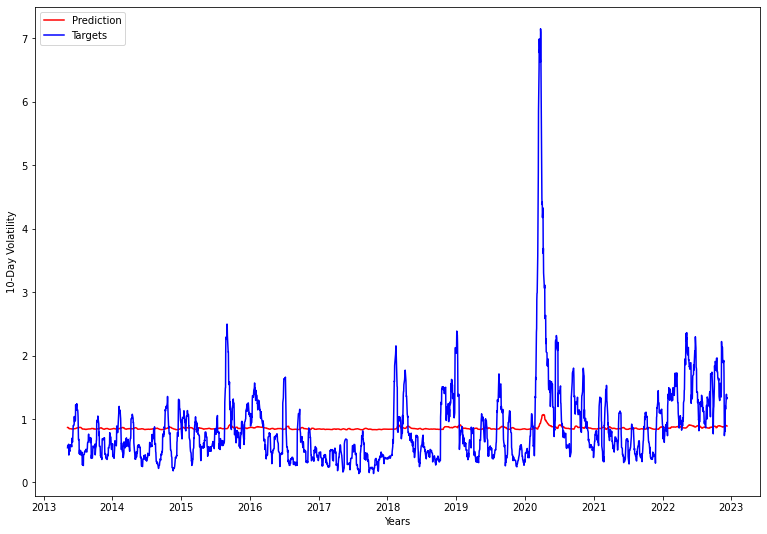

In [17]:
torch.cuda.empty_cache()
gc.collect()

val_preds, val_targets, val_loss = predict(val_loader, model)

test_preds, test_targets, test_loss = predict(test_loader, model)

loss = 'Eval loss : {:.07}'.format(val_loss)
print(loss)

loss = 'Test loss : {:.07}'.format(test_loss)
print(loss)

df = data.copy()
df = df.tail(len(test_preds))
df.drop(df.columns, inplace=True, axis=1)
df['preds'] = test_preds

# Generate output
plt.figure(figsize=(13,9))
plt.plot(df.index, test_preds, label="Prediction", color="red")
plt.plot(df.index, test_targets, label="Targets", color="blue")
plt.xlabel("Years")
plt.ylabel("10-Day Volatility")
plt.legend(loc="upper left")
plt.show()

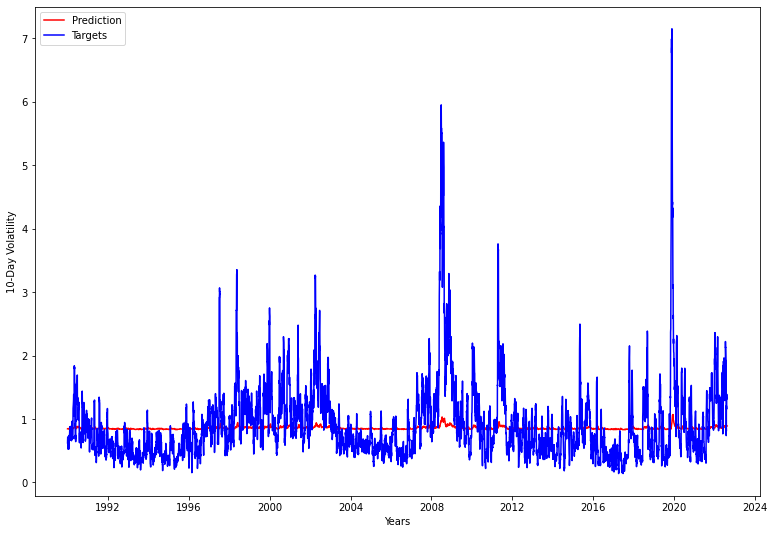

Whole dataset loss : 0.3791965


In [18]:
# Prediction for the entire dataset
data_loader = DataLoaderForVolatilityModeling(dataset, batch_size=1, sequence_length=config['look_back'], shuffle=False)

# Make predictions
preds, targets, loss = predict(data_loader, model)

# Generate output
plt.figure(figsize=(13,9))
plt.plot(data.index[:len(preds)], preds, label="Prediction", color="red")
plt.plot(data.index[:len(targets)], targets, label="Targets", color="blue")
plt.xlabel("Years")
plt.ylabel("10-Day Volatility")
plt.legend(loc="upper left")
plt.show()

loss = 'Whole dataset loss : {:.07}'.format(loss)
print(loss)